# STAT 301 Group Assignment
# 1. Title Page
**Type**: Final Group Project <br>
**Group 72 members**: Anthony Leong, Brian Ni, Shivani Aggarwal, Tina Yu <br> 
**TA**: Yian Lin

# 2. Introduction
## Background and Research Motivation

With the growth of peer-to-peer accommodation platforms, Airbnb has become a dominant player in the short-term rental market across major cities worldwide with over 5 million listings worldwide. The pricing of Airbnb listings varies significantly, driven by numerous listing and location-specific characteristics. There are numerous studies examining this relationship for various reasons:
- **Understanding what factors are associated with the variation in Airbnb prices can help both hosts optimize their listings and travelers make more informed booking decisions.**
- Scholars have argued that the existence of Airbnb listings raise the cost of living for local renters as landlords are switching their property to cater short-term rentals, decreasing supply for long-term renters and driving up the rental rates over time (Barron et al., 2019).
- The growth of Airbnb in neighbours that are not traditionally touristic brings economic growth to these areas, while also disrupting the hotel industry (Deboosere et al., 2019).

This raises the question - *what factors influence the success of Airbnbs and how are their prices determined?*

This is what we aim to study in this project. We will focus on Airbnb listings across 10 popular European cities - Amsterdam, Athens, Barcelona, Berlin, Budapest, Lisbon, London, Paris, Rome, Vienna. The dataset provides information about the characteristics of Airbnb listings and their prices. The listing prices are attributed to these characteristics such as room types, cleanliness and satisfaction ratings, number of bedrooms, and so on.


## Research Questions
Here is a formal description of the research questions we are interested in answering in the report through our analysis.
1. **How is price associated with the different characteristics of an Airbnb listing?**  
   - This question is exploratory and inferential. We are interested in identifying which features (e.g., room type, cleanliness rating, distance to city center) show meaningful associations with listing prices.

2. **Can we predict the price of an Airbnb listing based on its characteristics?**  
   - This question is predictive. We aim to build a model to estimate listing prices from available features, assessing model performance on unseen data.

> Both questions are answerable using the variables in our dataset, and align with the inference and prediction techniques we’ve learned in class.

# 3. Methods and Results
## A) Data
### Airbnb Prices in European Cities
This dataset provides information about Airbnb listings and their prices in 10 popular European cities - Amsterdam, Athens, Barcelona, Berlin, Budapest, Lisbon, London, Paris, Rome, Vienna. The listing prices are attributed to several characteristics such as room types, cleanliness and satisfaction ratings, number of bedrooms, and so on. Each city has two .csv files - for weekdays and weekends each.

The dataset contains 21 variables as described in the table below: 

| Variable | Description | Type |
| -------- | ----------- | ---- |
|`realSum`| The total price of the Airbnb listing| Numeric|
|`room_type`| The type of room being offered (private, shared, etc.)| Categorical|
|`room_shared`|	Whether the room is shared or not| Boolean|
|`room_private`| Whether the room is private or not| Boolean|
|`person_capacity`|	The maximum number of people that can stay in the room| Numeric|
|`host_is_superhost`|Whether the host is a superhost or not | Boolean|
|`multi`|	Whether the listing is for multiple rooms or not | Boolean|
|`biz`|	Whether the listing is for business purposes or not |Boolean|
|`cleanliness_rating`|	The cleanliness rating of the listing (0-10) |Numeric|
|`guest_satisfaction_overall`|	The overall guest satisfaction rating of the listing (0-100) | Numeric|
|`bedrooms`|	The number of bedrooms in the listing |Numeric|
|`dist`|	The distance from the city centre |Numeric|
|`metro_dist`|	The distance from the nearest metro station |Numeric|
|`atrr_index`| Attraction index determined by the number of reviews at nearby attractions | Numeric|
|`atrr_index_norm`| Normalized attraction index: scale to 100 | Numeric|
|`rest_index`| Restaurant index determined by the number of reviews at nearby restaurants | Numeric|
|`rest_index_norm`| Normalized restaurant index: scale to 100 | Numeric|
|`lng`|	The longitude of the listing |Numeric|
|`lat`|	The latitude of the listing |Numeric|

### Source of Data
This dataset is scraped off of a bigger dataset published in the article ***Determinants of Airbnb prices in European cities:  A spatial econometrics approach*** ([DOI link](https://doi.org/10.1016/j.tourman.2021.104319)) authored by Kristóf Gyódi and Łukasz1 Nawaro and published on January 13, 2021.

The dataset in the article is collected by web-scraping the Airbnb platform to look for accomodations for two people and two nights in 10 major European cities, 4-6 weeks in advance of the travel dates.

### Pre-selection of Variables
For the purpose of this assignment, we will use weekdays and weekends data from only 3 cities - Budapest, London, and Rome. This warrants the relevance of 6 .csv files with different number of observations. Below is a list of the observations in each file.
- `budapest_weekdays.csv`: $2,074$
- `budapest_weekends.csv`: $1,948$
- `london_weekdays.csv`: $4,614$
- `london_weekends.csv`: $5,379$
- `rome_weekdays.csv`: $4,492$
- `rome_weekends.csv`: $4,535$

Since the data is scattered across 6 .csv files, we will read in all of the files and combine them into one dataset, `airbnb`, with all the information. The total number of observations in the combined dataset will be $23,042$. We will do so by adding two columns:
- `city` which stores the values of the cities, and
- `weekend` which stores the value of 1 for weekends and 0 for weekdays.


We will also remove some variables we don't see fit when we conduct our analysis. Below is a detailed description of such variables:
- `X` which is the index value for each listing in each dataset (and it therefore has repetitions across different .csv files)
- `room_shared` and `room_private` since the type of room is already captured by the categorical variable `room_type`
- `attr_index` and `rest_index` as data for attraction and restaurant indices are captured by `attr_index_norm` and `rest_index_norm`
- `lat` and `lng` as the location of the listing will be captured by the new variable `city`

### Reading the data
We read in the data from our public GitHub repository which stores the required .csv files. 

We will add the columns `city` and `weekend` and remove the variable `X` when combining all the .csv files into one dataset named `airbnb`.

In [1]:
# required libraries
install.packages("tidyverse")
library(tidyverse)
library(repr)
library(broom)
library(ggplot2)
install.packages("glmnet", dependencies = TRUE)
library(glmnet)
install.packages("car")
library(car)

Installing package into 'C:/Users/admin/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\admin\AppData\Local\Temp\RtmpobTi0t\downloaded_packages


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into 'C:/Users/admin/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'glmnet' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'glmnet'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\admin\AppData\Local\R\win-library\4.5\00LOCK\glmnet\libs\x64\glmnet.dll to C:\Users\admin\AppData\Local\R\win-library\4.5\glmnet\libs\x64\glmnet.dll: Permission denied"
Warning message:
"restored 'glmnet'"



The downloaded binary packages are in
	C:\Users\admin\AppData\Local\Temp\RtmpobTi0t\downloaded_packages


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8

Installing package into 'C:/Users/admin/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'car' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\admin\AppData\Local\Temp\RtmpobTi0t\downloaded_packages


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




In [2]:
# loading data from public GitHub repo
bud_wd_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/budapest_weekdays.csv"
bud_we_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/budapest_weekends.csv"
lon_wd_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/london_weekdays.csv"
lon_we_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/london_weekends.csv"
rom_wd_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/rome_weekdays.csv"
rom_we_url <- "https://raw.githubusercontent.com/shivani-aggarw/stat301/refs/heads/main/data/rome_weekends.csv"

In [3]:
# reading in the .csv files and wrangling them
bud_wd <- read.csv(bud_wd_url)
bud_wd <- bud_wd  %>% 
    mutate(city = "Budapest",
          weekend = 0)  

bud_we <- read.csv(bud_we_url)
bud_we <- bud_we  %>% 
    mutate(city = "Budapest",
          weekend = 1)    

lon_wd <- read.csv(lon_wd_url)
lon_wd <- lon_wd  %>% 
    mutate(city = "London",
          weekend = 0) 

lon_we <- read.csv(lon_we_url)
lon_we <- lon_we  %>% 
    mutate(city = "London",
          weekend = 1)  

rom_wd <- read.csv(rom_wd_url)
rom_wd <- rom_wd  %>% 
    mutate(city = "Rome",
          weekend = 0)

rom_we <- read.csv(rom_we_url)
rom_we <- rom_we  %>% 
    mutate(city = "Rome",
          weekend = 1)  

In [4]:
# combining all datasets into one
airbnb <- rbind(bud_wd, bud_we, lon_wd, lon_we, rom_wd, rom_we)  %>% 
    dplyr::select(-X)

# visualizing the dataset
head(airbnb)
tail(airbnb)

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,⋯,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekend
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,238.9905,Entire home/apt,False,False,6,True,0,1,10,99,⋯,0.3593550,0.3526430,404.4047,24.116552,893.4773,67.65685,19.05074,47.50076,Budapest,0
2,300.7943,Entire home/apt,False,False,6,False,0,1,9,98,⋯,0.9294272,0.2002355,1676.8760,100.000000,452.5397,34.26770,19.04493,47.50405,Budapest,0
3,162.3819,Entire home/apt,False,False,4,True,0,0,10,98,⋯,2.4508403,0.2794518,163.5885,9.755551,191.9923,14.53825,19.02170,47.49882,Budapest,0
4,118.4377,Entire home/apt,False,False,2,False,0,0,9,92,⋯,1.5594494,0.4779711,191.7198,11.433155,326.2156,24.70205,19.06301,47.51126,Budapest,0
5,134.4174,Entire home/apt,False,False,4,True,1,0,10,99,⋯,1.1138030,0.2701016,198.6035,11.843658,635.5159,48.12322,19.06900,47.49900,Budapest,0
6,127.3676,Entire home/apt,False,False,4,False,1,0,9,91,⋯,0.2684703,0.1669317,635.6350,37.905903,1005.6535,76.15118,19.05480,47.50094,Budapest,0


,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,⋯,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekend
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
23037,270.4977,Entire home/apt,False,False,4,True,1,0,10,98,⋯,3.229875,0.4863988,531.8492,11.78335,1324.4773,28.85715,12.46433,41.90743,Rome,1
23038,413.8125,Entire home/apt,False,False,4,False,0,1,10,97,⋯,1.933569,0.2705916,657.3071,14.56293,1408.4076,30.68579,12.48137,41.90860,Rome,1
23039,582.3767,Entire home/apt,False,False,6,True,0,1,10,96,⋯,3.124166,1.9395050,540.3414,11.97150,1985.4354,43.25782,12.46700,41.89100,Rome,1
23040,878.5916,Entire home/apt,False,False,6,True,1,0,10,99,⋯,2.759242,1.1953387,759.3691,16.82416,1783.2686,38.85310,12.46900,41.90100,Rome,1
23041,447.2448,Entire home/apt,False,False,4,True,1,0,10,98,⋯,1.641598,0.8588370,1125.8572,24.94387,1687.8958,36.77516,12.48342,41.89634,Rome,1
23042,265.8219,Entire home/apt,False,False,6,False,0,1,10,96,⋯,4.411877,0.3524935,167.7019,3.71551,467.3403,10.18221,12.53000,41.86700,Rome,1


## B) Exploratory Data Analysis (EDA)
### Wrangling the data
We will start by cleaning the code by removing the pre-selected variables which we identified as redundant and useless in our analysis. These are `room_shared`, `room_private`, `attr_index`, `rest_index`, `lat`, and `lng`.
We will also add a column named `ID` to identify each row with a unique number to split the dataset.

In [5]:
# cleaning dataset
airbnb_clean <- airbnb %>%
    dplyr::select(-room_shared, -room_private, -attr_index_norm, -rest_index_norm, -lat, -lng) %>%
    mutate(ID = row_number())

### Visualization of Data

<font color = "red"> **(delete this before submitting)** </font> Include 2 effective and creative visualizations 
- explore the association of some potential explanatory variables with the response (use colours, point types, point size and/or faceting to include more variables)
- highlight potential problems (e.g., multicollinearity or outliers) 

In [ ]:
# visualization code

#### Interpretation of visualizations

### Summary Tables
<font color = "red"> **(delete before submitting)** </font>
Any summary tables that are relevant to your analysis (e.g., summarize number of observation in groups, indicate if NAs exist) - we can do total observations per city, number of NAs, maybe highest and lowest prices in each city

Be sure not to print output that takes up a lot of screen space!
Your EDA must be comprehensive with high quality plots.

# 5. References
Barron, K., Kung, E., & Proserpio, D. (2019). *When Airbnb Listings in a City Increase, So Do Rent Prices.* Harvard Business Review. https://ci.carmel.ca.us/sites/main/files/file-attachments/harvard_business_article_and_study.pdf

Deboosere, R., Kerrigan, D. J., Wachsmuth, D., & El-Geneidy, A. (2019). *Location, location and professionalization: a multilevel hedonic analysis of Airbnb listing prices and revenue.* Regional Studies, Regional Science, 6(1), 143–156. https://doi.org/10.1080/21681376.2019.1592699

Gyódi, K., & Nawaro Ł. (2021). *Determinants of Airbnb prices in European cities: A spatial econometrics approach*. https://doi.org/10.1016/j.tourman.2021.104319

## 2. Question <-- needs change
We are interested to explore 
> **What factors relate to higher guest satisfaction ratings?** 

<font color = "red"> This question helps us understand which attributes of a listing are associated with enhanced guests' experiences. Here, the response variable will be `guest_satisfication_overall`. <font>

<font color = "red"> We will determine the explanatory variables to be used in the model through the appropriate model selection techniques and by testing their VIF scores to avoid multicollinearity. </font>
<br>

### Purpose of the Model
The primary objective of this model is **inference-based** - to understand the key drivers of high guest satisfaction ratings. Understanding these drivers can help Airbnb hosts to control certain aspects of their listings to enhance guest experiences, ultimately influencing their future client base and revenue potential.

The model could have some predictive elements as we improve its predictive power by eliminating non-relevant variables through a model selection process. This, however, is not the main goal of this project.

In [5]:
# visualizing datatypes of each variable
str(airbnb)

'data.frame':	23042 obs. of  21 variables:
 $ realSum                   : num  239 301 162 118 134 ...
 $ room_type                 : chr  "Entire home/apt" "Entire home/apt" "Entire home/apt" "Entire home/apt" ...
 $ room_shared               : chr  "False" "False" "False" "False" ...
 $ room_private              : chr  "False" "False" "False" "False" ...
 $ person_capacity           : num  6 6 4 2 4 4 4 4 6 4 ...
 $ host_is_superhost         : chr  "True" "False" "True" "False" ...
 $ multi                     : int  0 0 0 0 1 1 0 0 0 0 ...
 $ biz                       : int  1 1 0 0 0 0 0 1 1 0 ...
 $ cleanliness_rating        : num  10 9 10 9 10 9 6 9 10 10 ...
 $ guest_satisfaction_overall: num  99 98 98 92 99 91 80 92 88 96 ...
 $ bedrooms                  : int  1 2 1 1 2 2 2 1 2 1 ...
 $ dist                      : num  0.359 0.929 2.451 1.559 1.114 ...
 $ metro_dist                : num  0.353 0.2 0.279 0.478 0.27 ...
 $ attr_index                : num  404 1677 164 192 199 ..

<font color = "red"> **Checking and removing NA values** </font>

In [6]:
# checking and removing NA values
sum(is.na(airbnb))

[1] 0

### Visualization <-- change or remove
<font color = "red"> We are interested in examining the relationship between our target variable, `guest_satisfaction_overall`, and select variables in the dataset. 
    
<font color = "red"> Particularly, we are interested in checking whether `cleanliness_rating` is associated with enhanced guests experiences. According to a study by American Hotel and Lodging Association ([source](https://hospitable.com/impact-of-cleanliness-on-guest-reviews/)),</font> 
<font color = 'blue'> **78% of the guests are highly likely to leave a positive review on the accomodation if it is clean and well-maintained**. </font> 
<font color = "red"> We can also imagine that hosts become Superhosts because of higher ratings, therefore the variable `host_is_superhost` could explain some variability in the response variable. In addition, we are curious about how price of the listing plays a role in satisfaction ratings - does a higher priced accomodation provide better amenities or only strains the wallet? Therefore, we will also incorporate `realSum` in our visualization. 
    
<font color = "red"> To isolate the the special characteristics of data influenced by geography, reflected in prices and the number of Airbnb listings, we will facet the plot with `city`. We will color the points on the scatterplot according to the host's profile (whether they are SuperHost or not) and vary the size of the points based on the listing price (larger points mean higher price).

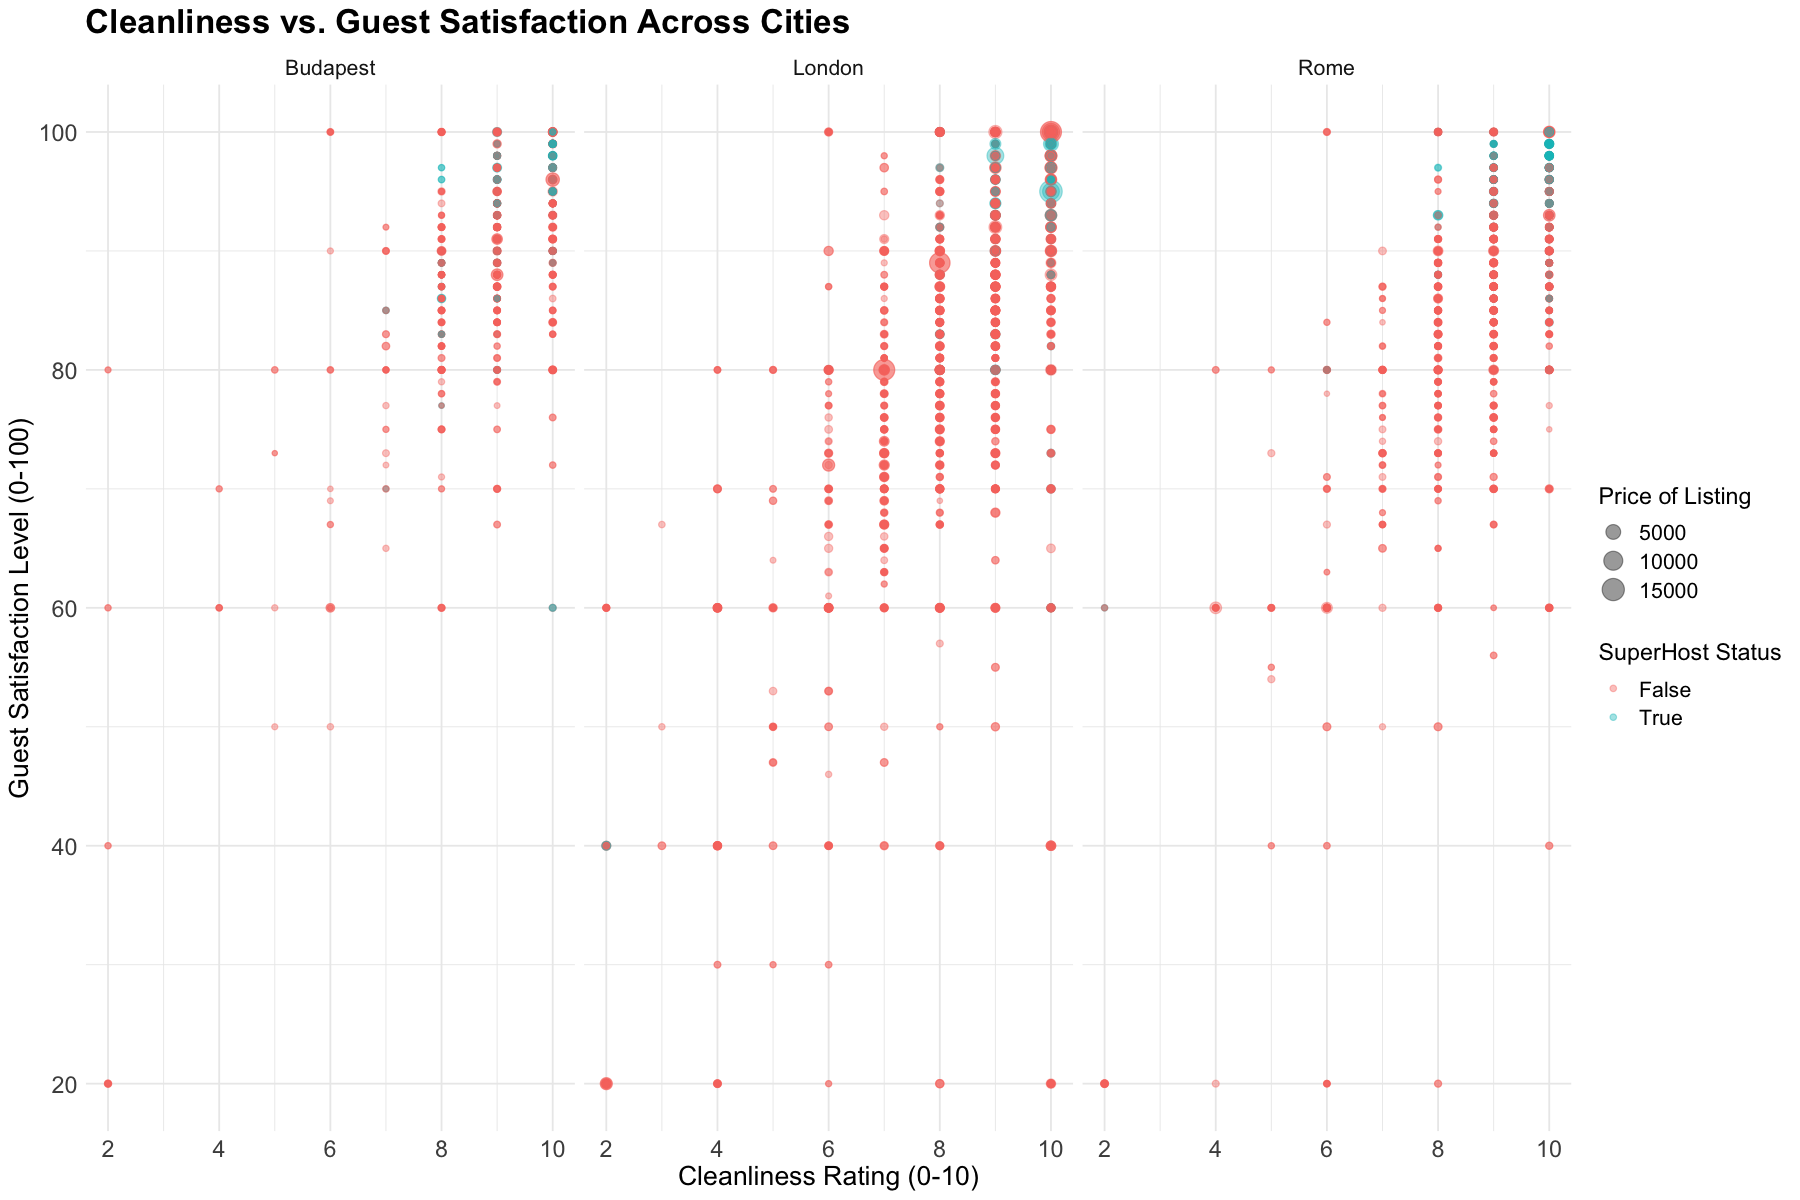

In [7]:
# increasing the size of the plot
options(repr.plot.width = 15, repr.plot.height = 10)

# plotting variables
ggplot(airbnb, 
       aes(
           x = cleanliness_rating, 
           y = guest_satisfaction_overall, 
           color = host_is_superhost, 
           size = realSum)) +
    geom_point(alpha = 0.4) +  
    facet_wrap(~ city) +  
    labs(
        title = "Cleanliness vs. Guest Satisfaction Across Cities",
        x = "Cleanliness Rating (0-10)", 
        y = "Guest Satisfaction Level (0-100)", 
        size = "Price of Listing", 
        color = "SuperHost Status") +
    theme_minimal() +
    theme(
        text = element_text(size = 16), 
        plot.title = element_text(size = 20, face = "bold"),  
        axis.title = element_text(size = 16),  
        axis.text = element_text(size = 14),  
        legend.title = element_text(size = 14)
    )

#### Interpretation
The scatterplot is very useful in understanding the relationship between the explanatory variables and guest satisfaction levels. It also visualizes the relationships among the explanatory variables to identify multicollinear covariates. Listed below are the insights driven by the chart.
- We can observe that the relationship between cleanliness rating and guest satisfaction levels is consistent across all cities.
- Cleanliness ratings are highly correlated with guest satisfaction levels, where high cleanliness rating is associated with higher satisfaction level.
- There are more listing with a low cleanliness rating (0-5) in London than there are in Budapest. This, however, could also be attributed to more Airbnb listings overall in London (9,993) than in and Budapest (4,022).
- Listings by SuperHosts (in turquoise) usually have higher cleanliness ratings and guest satisfaction levels.
- The price of the listing has little affect on its cleanliness ratings or satisfaction levels.
- Listings by SuperHosts can vary in price.
- London has the most expensive listings, followed by Budapest and Rome in that order.


We can observe that the explanatory variables identified above might be good covariates in the model for `guest_satisfaction_overall`. However, we need to be careful with covariates that might be highly correlated with each other, such as, `cleanliness_rating` and `host_is_superhost`. Using the VIF test, we can ensure that the model does not have such multicollinear covariates. We also need to account for irrelevant variables (here, `realSum`) that increase the coefficient of determination but do not explain the response variable well. An appropriate model selection processes will help us filter out such irrelevant variables and ensure that the model is a good fit.

# Implementation Stage <-- change according to question but use the code
<font color = "red"> (Assignment 1 feedback is addressed above in red)

## 1. Methods and Plan

To address our research question,
> **What factors relate to higher guest satisfaction ratings?**

we propose to use **Multi-variable Least Squares Regression** method. This will help us quantify the relationship between our quantitative response variable `guest_satisfaction_overall` and the selected explanatory variables. We will use the coefficient regularization technique, **LASSO - Least Absolute Shrinkage and Selection Operator** to improve model interpretability by selecting the most relevant predictors and reducing potential overfitting.

### Precautions from Potential Limitations of the Method
- To eliminate the bias in estimators resulting from the LASSO method, we will refit the model using LS and the variables selected by LASSO. 
- Additionally, to avoid the post-inference problem related to selecting variables and fitting the model on the same data, we will split the data and use 60% of rows to select the variables and 40% to test inference.
- We will select the $\lambda$ for LASSO selection that provides the lowest cross-validation MSE.
- At last, we will test the variables for multicollinearity using the VIF test as LS cannot weed multicollinear variables out.

### Assumptions in the Model
In order to use the ordinary least square regression, we first have to make the following assumptions:

- **Linearity**: The relationship between the response and explanatory variable is linear.
- **Independence**: The residual errors are independent of each other since we have a random sample. For example, the guest rankings for one city do not influence the ranking in another city.
- **Homoscedasticity**: The variance of residuals is constant across all levels of the explanatory variables.
- **Normality**: The conditional distribution of error is normal. This also reinstates the linearity assumption that the conditional expectation of the response is linear.
- **Non-multicollinearity**: There is no perfect correlation between two or more explanatory variables. We will also test for this assumption through a VIF test.

## 2. Computational Code and Output
### Implementing Pre-Selection of Variables
We will start by cleaning the code by removing variables that are redundant that are not needed in our analysis. These are listed below:
- `room_shared` and `room_private` since the type of room is already captured by the categorical variable `room_type`
- `attr_index_norm` and `rest_index_norm` as data for attraction and restaurant indices are captured by `attr_index` and `rest_index`
- `lat` and `lng` as the location of the listing will be captured by the new variable `city`

We will also add a column named `ID` to identify each row with a unique number to split the dataset.

### Splitting dataset
Now we will split the dataset and use 60% for selecting variables for the model using LASSO (`airbnb_selection`) and the remaining 40% for inference (`airbnb_inference`). We will also remove the variable `ID` from both `airbnb_selection` and `airbnb_inference` as it is not relevant for our regression.

In [9]:
# splitting dataset
airbnb_selection <- airbnb_clean %>%
    slice_sample(prop = 0.6)

airbnb_inference <- airbnb_clean %>%
    anti_join(airbnb_selection, by = 'ID')

airbnb_selection <- airbnb_selection %>% dplyr::select(-ID)
airbnb_inference <- airbnb_inference %>% dplyr::select(-ID)

head(airbnb_selection)

,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,city,weekend
,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,400.0187,Entire home/apt,6,False,0,1,9,92,2,2.677974,1.28969702,831.3151,2365.7708,Rome,0
2,148.8746,Private room,2,False,1,0,8,85,1,4.288810,0.27455543,348.2243,591.8718,London,0
3,265.5284,Entire home/apt,2,False,0,0,7,80,1,5.308039,0.15187774,206.9059,497.7799,London,1
4,294.6918,Shared room,5,False,0,0,9,90,1,7.591270,0.37818001,163.2951,339.9248,London,0
5,195.9180,Private room,2,False,1,0,9,100,1,3.785346,0.07452444,522.9359,1347.8926,Rome,1
6,706.2725,Entire home/apt,6,False,0,1,10,93,2,2.296313,0.17577480,445.4081,974.7859,London,1


### LASSO Model Selection
We will start by finding the $\lambda$ that provides the lowest cross validation MSE using `cv.glmnet` and then find the resulting coefficients and covariates from that lasso model.

In [10]:
# finding the lambda with the lowest cross validation MSE
set.seed(2025)

lasso_model <- cv.glmnet(
    x = model.matrix(guest_satisfaction_overall ~ ., data = airbnb_selection)[, -1], 
    y = airbnb_selection$guest_satisfaction_overall, 
    alpha = 1)

# extracting coefficients of the best LASSO model
beta_lasso <- coef(lasso_model, s = "lambda.min")

lasso_model
beta_lasso


Call:  cv.glmnet(x = model.matrix(guest_satisfaction_overall ~ ., data = airbnb_selection)[,      -1], y = airbnb_selection$guest_satisfaction_overall, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min 0.0123    69   37.71 1.440      13
1se 0.6136    27   39.01 1.466       3

17 x 1 sparse Matrix of class "dgCMatrix"
                                 s1
(Intercept)           32.4742665933
realSum                0.0002231055
room_typePrivate room  0.5407489059
room_typeShared room   .           
person_capacity        .           
host_is_superhostTrue  1.6601343017
multi                 -0.7187694977
biz                   -2.4113732608
cleanliness_rating     6.5175563944
bedrooms               0.2945957768
dist                  -0.0340037840
metro_dist             0.2692003341
attr_index             0.0005432394
rest_index             .           
cityLondon            -1.5926900620
cityRome              -1.7075760300
weekend                0.0204642651

In [11]:
# extracting covariates selected by LASSO
lasso_covariates <- as_tibble(
    as.matrix(beta_lasso),
    rownames='covariate') %>%
    filter(covariate != '(Intercept)' & abs(s1) !=0) %>% 
    pull(covariate)

lasso_covariates

[1] "realSum"               "room_typePrivate room" "host_is_superhostTrue"
 [4] "multi"                 "biz"                   "cleanliness_rating"   
 [7] "bedrooms"              "dist"                  "metro_dist"           
[10] "attr_index"            "cityLondon"            "cityRome"             
[13] "weekend"

### Checking for Multicollinearity
It looks like the LASSO method removed the variables `person_capacity` and `rest_index` from our list of explanatory variables. To ensure that the selected covariates are suitable for our regression model, we will first check its **VIF score**.

In [18]:
# checking vif scores
lasso_variables_vif <- vif(lm(guest_satisfaction_overall ~ realSum + room_type + host_is_superhost + multi + biz +
                              cleanliness_rating + bedrooms + dist + metro_dist + attr_index + city + weekend,
                              data = airbnb_selection))
lasso_variables_vif

,GVIF,Df,GVIF^(1/(2*Df))
realSum,1.273306,1,1.128409
room_type,1.308095,2,1.069448
host_is_superhost,1.129592,1,1.062823
multi,1.428924,1,1.195376
biz,1.533724,1,1.238436
cleanliness_rating,1.116211,1,1.056509
bedrooms,1.115600,1,1.056220
dist,3.437487,1,1.854046
metro_dist,1.851171,1,1.360577
attr_index,1.900411,1,1.378554


#### Further Analysis for Multicollinearity
Although, none of the covariates have a VIF score greater than 5 or 10 which indicates high multicollinearity, `dist` has the highest VIF scores as compared to the other covariates. This could be due to the following reason:

`dist` could have a correlation with `metro_dist`, `biz` or `attr_index`. This is because a lot of metro stations are close to city centres, accomodations listed for business purpose are usually near or in the city centres, and listings close to city centres are likely to have a better attraction index as city centres are built around the tourist attractions of the city. We will check the correlation between `dist` and each of `metro_dist`, `biz` and `attr_index`. **If the correlation is high, we will drop `dist`** as it has the highest VIF score.

In [19]:
# checking correlations
cor(airbnb_selection$dist, airbnb_selection$metro_dist)
cor(airbnb_selection$dist, airbnb_selection$biz)
cor(airbnb_selection$dist, airbnb_selection$attr_index)

[1] 0.619816

[1] -0.1755018

[1] -0.468169

#### Selecting Variables with Acceptable VIF
As per our analysis above, we have found that the correlations between `dist` and `metro_dist`, and `dist` and `attr_index` are quite high. Using all of the LASSO covariates is, hence, unsuitable for the regression model. Thus, we will remove `dist` from our regression model.

#### Checking VIF Scores again
Lets examine if our selected variables faired well in terms of multicollinearity. If the VIF scores are less than 3, we will go ahead with implementing our regression model using these covariates.

In [21]:
# checking vif scores
variables_vif <- vif(lm(guest_satisfaction_overall ~ realSum + room_type + host_is_superhost + multi + biz +
                        cleanliness_rating + bedrooms + metro_dist + attr_index + city + weekend,
                              data = airbnb_selection))
variables_vif

,GVIF,Df,GVIF^(1/(2*Df))
realSum,1.267190,1,1.125695
room_type,1.307463,2,1.069319
host_is_superhost,1.129530,1,1.062794
multi,1.428227,1,1.195084
biz,1.527918,1,1.236090
cleanliness_rating,1.115807,1,1.056317
bedrooms,1.114469,1,1.055684
metro_dist,1.114955,1,1.055914
attr_index,1.388773,1,1.178462
city,1.743318,2,1.149064


### Multi-Linear Regression Model
We have finally filtered through all the variables and selected covariates appropriate for our regression model. We will introduce an interaction term between `city` and `realSum` to not let their correlation affect our model. We will implement the model on the remaining 40% of the data to avoid the post-inference problem.

In [22]:
# implementing our model
airbnb_model <- lm(guest_satisfaction_overall ~ realSum + room_type + host_is_superhost + multi + biz +
                   cleanliness_rating + bedrooms + metro_dist + attr_index + city + weekend,
                   data = airbnb_inference)
summary(airbnb_model)

tidy_model <- tidy(airbnb_model, conf.int = TRUE)
tidy_model


Call:
lm(formula = guest_satisfaction_overall ~ realSum + room_type + 
    host_is_superhost + multi + biz + cleanliness_rating + bedrooms + 
    metro_dist + attr_index + city + weekend, data = airbnb_inference)

Residuals:
    Min      1Q  Median      3Q     Max 
-74.856  -2.163   0.665   3.166  33.022 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           29.2826829  0.7068326  41.428  < 2e-16 ***
realSum                0.0001045  0.0002405   0.435 0.663760    
room_typePrivate room  0.4930683  0.1553388   3.174 0.001508 ** 
room_typeShared room   0.8360577  1.2633636   0.662 0.508134    
host_is_superhostTrue  1.4379040  0.1609797   8.932  < 2e-16 ***
multi                 -0.9104830  0.1700155  -5.355 8.75e-08 ***
biz                   -2.6294996  0.1708747 -15.388  < 2e-16 ***
cleanliness_rating     6.8939276  0.0703794  97.954  < 2e-16 ***
bedrooms               0.4113625  0.1207676   3.406 0.000661 ***
metro_dist             0.27

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),29.2826829183,0.7068325908,41.42803162,0.000000e+00,27.8971342725,30.6682315641
realSum,0.0001045439,0.0002404735,0.43474212,6.637598e-01,-0.0003668374,0.0005759253
room_typePrivate room,0.4930682960,0.1553388274,3.17414715,1.507724e-03,0.1885697416,0.7975668503
room_typeShared room,0.8360576706,1.2633636236,0.66177121,5.081344e-01,-1.6404152324,3.3125305736
host_is_superhostTrue,1.4379039786,0.1609796835,8.93220776,4.980595e-19,1.1223480953,1.7534598619
multi,-0.9104829675,0.1700154963,-5.35529400,8.747747e-08,-1.2437510479,-0.5772148872
biz,-2.6294995998,0.1708746517,-15.38847087,8.857520e-53,-2.9644518152,-2.2945473844
cleanliness_rating,6.8939276165,0.0703794147,97.95375038,0.000000e+00,6.7559683544,7.0318868787
bedrooms,0.4113624762,0.1207676488,3.40623073,6.614821e-04,0.1746310996,0.6480938528


### Output
#### Visualization
To visualize the results of the regression, we are using a **coefplot** (short for coefficient plot). This plot displays the coefficients and their confidence intervals. We can see the magnitude and direction of each coefficient, along with their 95% confidence intervals, making it easy to interpret the significance and impact of each variable on the response.

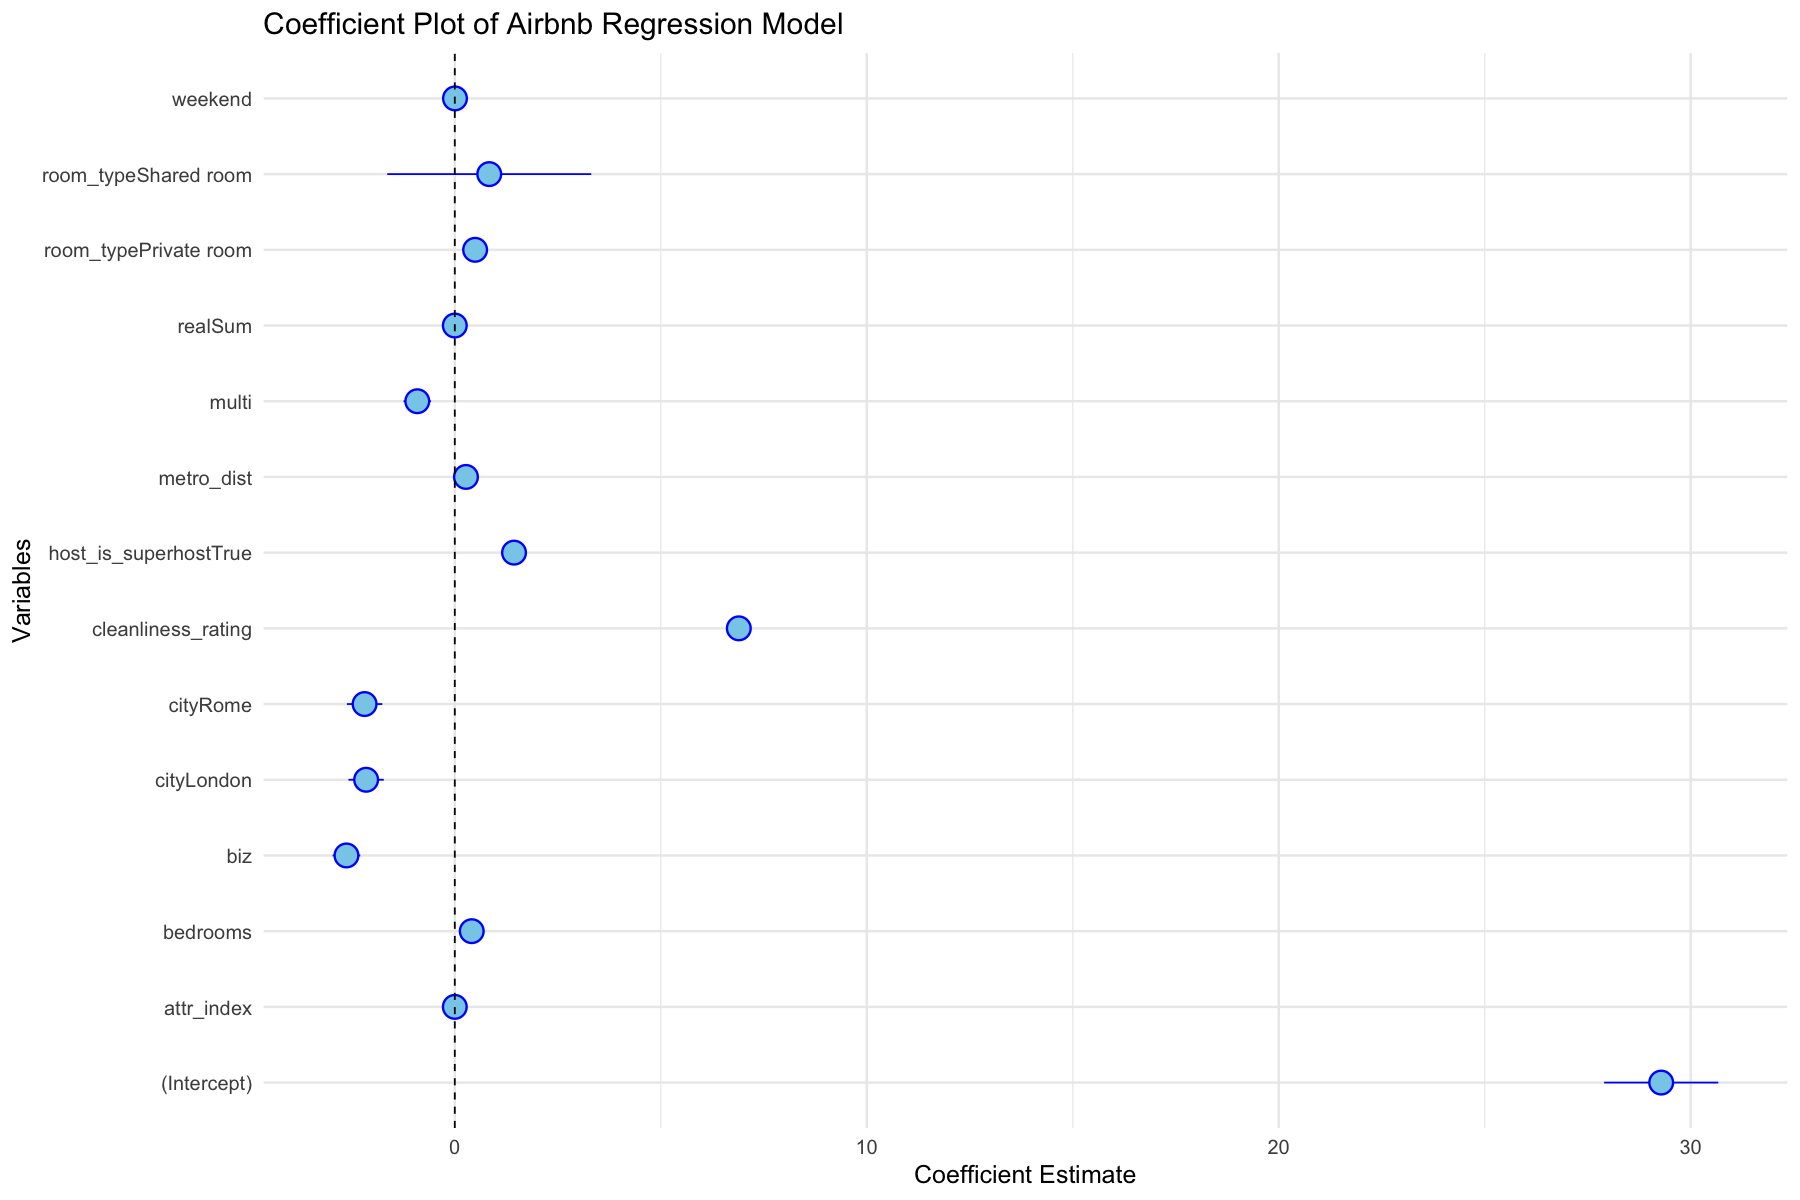

In [23]:
# visual code
ggplot(tidy_model, aes(
    x = term,
    y = estimate,
    ymin = conf.low,
    ymax = conf.high)) +
    geom_pointrange(color = "blue", size = 1.5, shape = 21, fill = "skyblue") +
    coord_flip() + 
    theme_minimal(base_size = 15) +
    labs(title = "Coefficient Plot of Airbnb Regression Model", 
         x = "Variables", 
         y = "Coefficient Estimate") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black")

#### Interpretation
The model explains $57.75$% of the variance in `guest_satisfaction_overall`. It shows that higher cleanliness ratings, SuperHost status, and business listings significantly explain guest satisfaction, while the price of the listing, room types, and weekdays have significantly less association. Notably, Budapest has an overall higher guest satisfaction ratings than London and Rome. 

However, the lower significance of price in the model indicates that **other factors, like cleanliness and amenities provided by SuperHosts and in business listings, are more important in enhancing guest satisfaction.** 